## Modeling Notebook

In [1]:
import pandas as pd
import yfinance as yf
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [11]:
# Reading in most recent data
stock_data = pd.read_csv('data/WithCashFlowDataNoOutliers.csv')
stock_data.drop(['Index'], axis = 1, inplace = True)
stock_data.dropna(inplace = True)
stock_data.head()

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
0,A,166.5,14,138.09,4.088458e+10,0.206,1,4.930681e+10,6.848000e+09,1.985000e+09,0.10102,80000000.0,529000000.0,1.353000e+09,41000000.0
1,AA,50.0,11,39.43,7.032538e+09,0.268,1,8.917258e+09,1.245100e+10,2.142000e+09,0.05931,-231000000.0,299000000.0,8.220000e+08,0.0
2,AAN,16.0,5,9.54,2.936460e+08,0.677,1,4.924443e+08,2.249434e+09,7.345500e+08,0.06360,0.0,403930000.0,1.704320e+08,0.0
3,AAOI,3.4,4,2.11,6.130162e+07,0.611,1,9.875690e+07,2.228180e+08,-3.543400e+07,-0.08548,24643000.0,11253000.0,-1.402200e+07,0.0
4,AAP,155.0,17,120.21,7.122887e+09,0.289,1,9.181402e+09,1.115472e+10,9.909550e+08,0.03891,0.0,156733000.0,7.222220e+08,0.0


In [12]:
stock_data.describe()

,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
count,2136.000000,2136.000000,2136.000000,2.136000e+03,2136.000000,2136.000000,2.136000e+03,2.136000e+03,2.136000e+03,2136.000000,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03
mean,68.737004,9.224719,57.130066,8.593780e+09,0.699404,0.590824,1.009959e+10,3.756765e+09,7.172493e+08,-0.043569,3.178887e+07,4.478589e+08,5.049861e+08,2.450304e+06
std,135.298078,4.647385,123.570656,1.785242e+10,1.155297,0.569473,1.992935e+10,7.018417e+09,1.436034e+09,0.199080,1.349144e+08,1.004820e+09,1.034982e+09,9.799373e+07
min,0.600000,4.000000,0.240000,2.822783e+07,-0.151000,-1.000000,4.259801e+07,0.000000e+00,-9.360000e+08,-1.000000,-4.180000e+08,-1.514000e+09,-5.137450e+08,-1.710000e+09
25%,13.500000,5.000000,8.092500,6.621685e+08,0.132000,0.000000,1.143221e+09,2.161578e+08,-3.682400e+07,-0.096987,0.000000e+00,6.043031e+06,-2.850175e+07,0.000000e+00
50%,32.000000,8.000000,23.620000,2.354210e+09,0.286000,1.000000,3.160352e+09,1.036120e+09,1.823625e+08,0.022365,0.000000e+00,9.987600e+07,1.190055e+08,0.000000e+00
75%,78.000000,12.000000,64.187500,7.147960e+09,0.666250,1.000000,8.739960e+09,4.018505e+09,8.048250e+08,0.060735,7.383500e+06,4.685705e+08,5.648008e+08,0.000000e+00
max,2800.000000,20.000000,2615.600000,1.972006e+11,8.231000,1.000000,2.271751e+11,1.091200e+11,1.257500e+10,0.238460,1.309928e+09,8.335000e+09,7.762000e+09,2.518713e+09


In [13]:
stock_data

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
0,A,166.5,14,138.09,4.088458e+10,0.206,1,4.930681e+10,6.848000e+09,1.985000e+09,0.10102,80000000.0,529000000.0,1.353000e+09,41000000.0
1,AA,50.0,11,39.43,7.032538e+09,0.268,1,8.917258e+09,1.245100e+10,2.142000e+09,0.05931,-231000000.0,299000000.0,8.220000e+08,0.0
2,AAN,16.0,5,9.54,2.936460e+08,0.677,1,4.924443e+08,2.249434e+09,7.345500e+08,0.06360,0.0,403930000.0,1.704320e+08,0.0
3,AAOI,3.4,4,2.11,6.130162e+07,0.611,1,9.875690e+07,2.228180e+08,-3.543400e+07,-0.08548,24643000.0,11253000.0,-1.402200e+07,0.0
4,AAP,155.0,17,120.21,7.122887e+09,0.289,1,9.181402e+09,1.115472e+10,9.909550e+08,0.03891,0.0,156733000.0,7.222220e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,ZTS,205.0,12,167.65,7.813697e+10,0.223,1,9.556151e+10,8.080000e+09,3.461000e+09,0.12966,423000000.0,304000000.0,1.912000e+09,0.0
2149,ZVIA,5.0,7,3.77,2.432781e+08,0.326,1,3.225868e+08,1.631810e+08,-4.652100e+07,-0.26721,0.0,25009000.0,-2.077800e+07,0.0
2150,ZVRA,19.0,5,5.47,1.889360e+08,2.473,1,6.561747e+08,1.045800e+07,-2.313800e+07,-0.12497,944000.0,-18192000.0,-1.871700e+07,0.0
2151,ZWS,27.5,6,20.22,3.595015e+09,0.360,1,4.889220e+09,1.281800e+09,1.806000e+08,0.03945,0.0,370900000.0,9.700000e+07,0.0


We're now ready to set up our first model

In [14]:
first_model_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF','OverallRecommendation']]
first_model_df.set_index('Ticker', inplace = True)

In [15]:
X = first_model_df.drop(['OverallRecommendation'], axis = 1)
y = first_model_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

In [16]:
smt = SMOTE(random_state = 42)
ss = StandardScaler()
rfc = RandomForestClassifier(random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest',rfc)])

0.6187134502923977


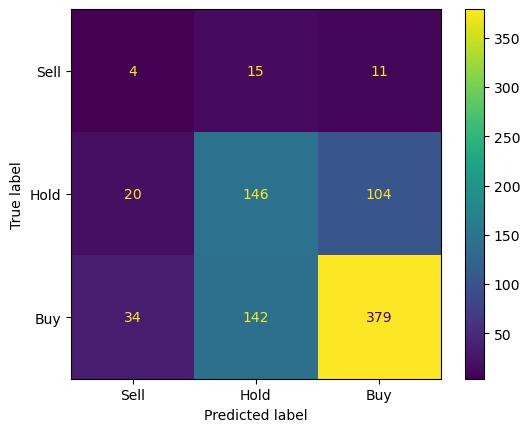

In [17]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Hold','Buy']).plot()

Hyper Parameter Tuning

In [30]:
rfc_params = {'random_forest__max_depth': [25,30,35,40,45,50], 'random_forest__n_estimators': [25,30,35,40,45,50]}

In [31]:
gs = GridSearchCV(rfc_pipeline, rfc_params, cv = 5, scoring = 'accuracy', verbose = 1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_depth': [25, 30, 35, 40, 45, 50],
                         'random_forest__n_estimators': [25, 30, 35, 40, 45,
                                                         50]},
             scoring='accuracy', verbose=1)

In [32]:
gs.best_params_

{'random_forest__max_depth': 25, 'random_forest__n_estimators': 45}

In [33]:
gs.best_score_

0.6260548394941634

Updating Parameters

In [34]:
rfc = RandomForestClassifier(max_depth = 25, n_estimators = 45, random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest',rfc)])

0.6116959064327485


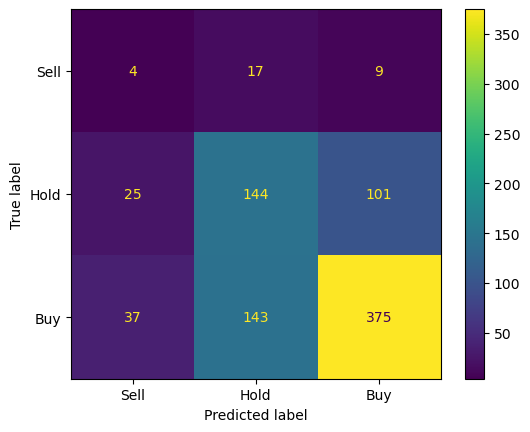

In [35]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Hold','Buy']).plot()